In [1]:
import os
api_key=os.getenv("OPENAI_API_KEY")
f"{api_key}"

'euri-4f0602430b4d9f104e1a21d375f893ba06fa5b0d9b32844abd5d64202f493a7b'

In [2]:
import requests
from dotenv import load_dotenv
import os
load_dotenv()
api_key=os.getenv('OPENAI_API_KEY')

url = "https://api.euron.one/api/v1/euri/embeddings"
headers = {
    "Content-Type": "application/json",
    "Authorization": b"Bearer euri-4f0602430b4d9f104e1a21d375f893ba06fa5b0d9b32844abd5d64202f493a7b"
}

payload = {
    "input": ["hello world", "machine learning is cool"],
    "model": "text-embedding-3-small"
}

response = requests.post(url, headers=headers, json=payload)
print("Status:", response.status_code)
print("Response:", response.text)


Status: 200
Response: {"object":"list","data":[{"object":"embedding","embedding":[-0.006763331,-0.03919632,0.034175806,0.028762115,-0.02478502,-0.042039264,-0.030289441,0.049328085,-0.013897153,-0.017647417,0.015363989,-0.027038202,-0.020974265,-0.027854793,0.008619561,0.035627518,-0.053683233,-0.002272086,0.008808587,0.047997344,0.03710948,-0.009247126,-0.008778343,0.0114020165,0.014078617,-0.0021624514,-0.03756314,0.0454266,0.011250796,-0.039649982,0.02345428,-0.05062858,0.012044703,-0.000015505995,0.01602936,0.0061357664,0.031967986,0.0033608729,-0.008604439,-0.010555182,-0.037381675,-0.03450849,0.049993455,0.019371329,-0.014275203,0.015265697,-0.054348603,0.050416872,0.0454266,0.053713474,-0.0015405576,0.018524496,0.03556703,0.115955785,-0.013262027,-0.04092023,0.013383003,0.047694907,-0.014948133,0.024679165,0.032179695,0.01336032,0.017027413,0.024845507,0.013383003,0.008990051,-0.024361601,-0.00039435437,-0.00064457685,0.053864695,-0.0025140387,0.037744604,-0.01870596,-0.01150787

In [3]:
pwd

'e:\\GENAI\\clinical-rag\\notebooks'

In [4]:
cd ..

e:\GENAI\clinical-rag


c:\Users\santh\anaconda3\envs\rag\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [5]:
from langchain_community.document_loaders import DirectoryLoader,PyPDFLoader,DirectoryLoader
from pathlib import Path
data_dir = "data/HealthCareSectorinindia-AnOverview.pdf"

dir_loader=PyPDFLoader(file_path=data_dir)
# pdf_loader = DirectoryLoader(
#             data_dir,
#             glob="**/*.pdf",
#             loader_cls=PyPDFLoader
#         )


In [4]:
dir_loader.load()

[Document(page_content="Health Care System in India : An Overview \nA. Sheeba ∗ \n   Dr. A. Seilan ∗∗ \nThis article published in the edited book titled : International issues on Health Economics \nand Management \nEdited By : Dr. Arulraj \nPublished  by : \nTISSL International Publications,  \nNew Delhi, India \nYear of Publication : 2010 \nPages in which this article appears : 215-218 \nISBN No. : 978-93-80449-15-9 \n \nHealth care is the prevention, treatment, and management of illness and the preservation of \nmental and physical well being through the services offered by the medical, nursing, and allied health \nprofessions. According to the World Health Organisation, health care embraces all the goods and \nservices designed to promote health, including “preventive, curative and palliative interventions, \nwhether directed to individuals or to populations”. The organised provision of such services may \nconstitute a health care system.  \nHealth is defined as a state of complete 

In [36]:
import fitz  # pymupdf
import pytesseract
from PIL import Image
import io
import matplotlib.pyplot as plt

def extract_text_from_pdf_images(pdf_path: str) -> str:
    """
    Extract images from PDF pages and run OCR on them
    """
    text = ""

    doc = fitz.open(pdf_path)

    for page_num in range(len(doc)):
        page = doc[page_num]

        image_list = page.get_images(full=True)
        print(image_list)

        for img_index, img in enumerate(image_list):

            xref = img[0]
            base_image = doc.extract_image(xref)

            image_bytes = base_image["image"]

            image = Image.open(io.BytesIO(image_bytes))
            plt.imshow(image)
            text += pytesseract.image_to_string(image)

    return text.strip()


In [39]:
import uuid
from typing import List

from langchain_community.document_loaders import DirectoryLoader, PyPDFLoader, TextLoader, UnstructuredWordDocumentLoader,UnstructuredImageLoader

from app.dataclasses import RawDocument

class DocumentLoader:

    def __init__(self, folder_path: str):
        self.folder_path = folder_path

    def load(self) -> List[RawDocument]:

        docs = []

        # 1. Normal PDF TEXT
        pdf_loader = DirectoryLoader(
            self.folder_path,
            glob="**/*.pdf",
            loader_cls=PyPDFLoader
        )

        for lc_doc in pdf_loader.load():
            text = lc_doc.page_content

            # 2. OCR on images inside same PDF
            source = lc_doc.metadata.get("source")

            if source:
                pdf_path = f"{source}"
                image_text = extract_text_from_pdf_images(pdf_path)

                # Combine them
                text = text + "\n" + image_text

            docs.append(
                RawDocument(
                    id=str(uuid.uuid4()),
                    text=text,
                    metadata=lc_doc.metadata
                )
            )

        # 3. Other file types
        other_loaders = [
            DirectoryLoader(self.folder_path, glob="**/*.txt", loader_cls=TextLoader),
            DirectoryLoader(self.folder_path, glob="**/*.docx", loader_cls=UnstructuredWordDocumentLoader),
            DirectoryLoader(
                self.folder_path,
                glob="**/*.[pj][pn]g",
                loader_cls=UnstructuredImageLoader 
            )
        ]

        for loader in other_loaders:
            for lc_doc in loader.load():
                docs.append(
                    RawDocument(
                        id=str(uuid.uuid4()),
                        text=lc_doc.page_content,
                        metadata=lc_doc.metadata
                    )
                )

        return docs

doc_loader=DocumentLoader("data")


In [1]:
import pytesseract
print(pytesseract.get_tesseract_version())


5.5.0.20241111


In [50]:
import pandas as pd
df = pd.DataFrame({
    'A': [10, 20, 30],
    'B': ["tamil", 50, 60],
    'C': [70, 80, 90]
})
print(df)
# Get the first row as a Series
first_row_series = df.head(1).squeeze()

print(first_row_series[0])
print(first_row_series[1])

# print(type(first_row_series))

    A      B   C
0  10  tamil  70
1  20     50  80
2  30     60  90
10
tamil


C:\Users\santh\AppData\Local\Temp\ipykernel_97596\1933051957.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(first_row_series[0])
C:\Users\santh\AppData\Local\Temp\ipykernel_97596\1933051957.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(first_row_series[1])


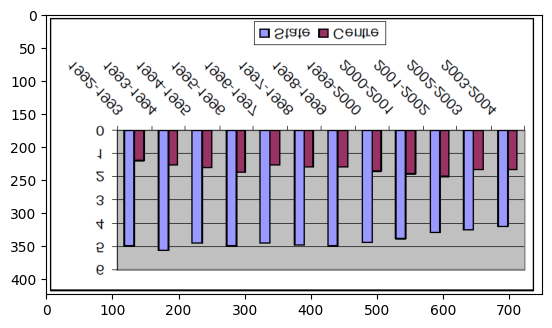

In [24]:
pdf_path = "data/HealthCareSectorinindia-AnOverview.pdf"   # <-- change to your real PDF name
image_text = extract_text_from_pdf_images(pdf_path)

In [26]:
docs

[RawDocument(id='ed970201-e59c-439c-9b89-81b9eb73d0e0', text="Health Care System in India : An Overview \nA. Sheeba ∗ \n   Dr. A. Seilan ∗∗ \nThis article published in the edited book titled : International issues on Health Economics \nand Management \nEdited By : Dr. Arulraj \nPublished  by : \nTISSL International Publications,  \nNew Delhi, India \nYear of Publication : 2010 \nPages in which this article appears : 215-218 \nISBN No. : 978-93-80449-15-9 \n \nHealth care is the prevention, treatment, and management of illness and the preservation of \nmental and physical well being through the services offered by the medical, nursing, and allied health \nprofessions. According to the World Health Organisation, health care embraces all the goods and \nservices designed to promote health, including “preventive, curative and palliative interventions, \nwhether directed to individuals or to populations”. The organised provision of such services may \nconstitute a health care system.  \nHea

In [27]:
keyword="The government expenditure"
if keyword.lower() in image_text.lower():
    print(image_text)

In [30]:
from langchain_community.document_loaders import PyMuPDFLoader

mupdf=PyMuPDFLoader(file_path=pdf_path)

In [33]:
mupdf.load()

[Document(page_content="Health Care System in India : An Overview \nA. Sheeba ∗ \n   Dr. A. Seilan ∗∗ \nThis article published in the edited book titled \n: International issues on Health Economics \nand Management \nEdited By \n: Dr. Arulraj \nPublished  by \n: TISSL \nInternational \nPublications, \nNew Delhi, India \nYear of Publication \n: 2010 \nPages in which this article appears \n: 215-218 \nISBN No. \n: 978-93-80449-15-9 \n \nHealth care is the prevention, treatment, and management of illness and the preservation of \nmental and physical well being through the services offered by the medical, nursing, and allied health \nprofessions. According to the World Health Organisation, health care embraces all the goods and \nservices designed to promote health, including “preventive, curative and palliative interventions, \nwhether directed to individuals or to populations”. The organised provision of such services may \nconstitute a health care system.  \nHealth is defined as a state

In [41]:
pip install rapidocr-onnxruntime

  Using cached pyclipper-1.3.0.post6-cp310-cp310-win_amd64.whl.metadata (9.2 kB)
  Using cached shapely-2.1.2-cp310-cp310-win_amd64.whl.metadata (7.1 kB)
   ---------------------------------------- 0.0/14.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/14.9 MB ? eta -:--:--
   -- ------------------------------------- 1.0/14.9 MB 5.0 MB/s eta 0:00:03
   ------ --------------------------------- 2.4/14.9 MB 5.6 MB/s eta 0:00:03
   ---------- ----------------------------- 3.9/14.9 MB 6.2 MB/s eta 0:00:02
   ------------- -------------------------- 5.0/14.9 MB 6.2 MB/s eta 0:00:02
   --------------- ------------------------ 5.8/14.9 MB 5.6 MB/s eta 0:00:02
   ------------------ --------------------- 6.8/14.9 MB 5.3 MB/s eta 0:00:02
   --------------------- ------------------ 7.9/14.9 MB 5.4 MB/s eta 0:00:02
   ---------------------- ----------------- 8.4/14.9 MB 5.4 MB/s eta 0:00:02
   ---------------------- ----------------- 8.4/14.9 MB 5.4 MB/s eta 0:00:02
   ----------

In [ ]:
pdf=PyPDFLoader(file_path=pdf_path,extract_images=True)
pdf.load()

[Document(page_content="Health Care System in India : An Overview \nA. Sheeba ∗ \n   Dr. A. Seilan ∗∗ \nThis article published in the edited book titled : International issues on Health Economics \nand Management \nEdited By : Dr. Arulraj \nPublished  by : \nTISSL International Publications,  \nNew Delhi, India \nYear of Publication : 2010 \nPages in which this article appears : 215-218 \nISBN No. : 978-93-80449-15-9 \n \nHealth care is the prevention, treatment, and management of illness and the preservation of \nmental and physical well being through the services offered by the medical, nursing, and allied health \nprofessions. According to the World Health Organisation, health care embraces all the goods and \nservices designed to promote health, including “preventive, curative and palliative interventions, \nwhether directed to individuals or to populations”. The organised provision of such services may \nconstitute a health care system.  \nHealth is defined as a state of complete 

In [2]:
from rank_bm25 import BM25Okapi
docs=['this is a notebook of 10 rs','Deep learning is based on neural networks',"ML has superivised and unsupervised learning"]
chunks=[doc.split() for doc in docs ]
chunks

[['this', 'is', 'a', 'notebook', 'of', '10', 'rs'],
 ['Deep', 'learning', 'is', 'based', 'on', 'neural', 'networks'],
 ['ML', 'has', 'superivised', 'and', 'unsupervised', 'learning']]

In [4]:
bm25=BM25Okapi(chunks)

In [6]:
text="superivised learning"
bm25.get_scores(text.split())

array([0.        , 0.09714152, 0.63890349])

In [9]:

import requests
import numpy as np
import os

def generate_embeddings(text):
    url = "https://api.euron.one/api/v1/euri/embeddings"
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {os.getenv('OPENAI_API_KEY')}"
    }
    payload = {
        "input": text,
        "model": "text-embedding-3-small"
    }

    response = requests.post(url, headers=headers, json=payload)
    data = response.json()
    
    embedding = np.array(data['data'][0]['embedding'])
    
    return embedding

text = "The weather is sunny today."

embedding = generate_embeddings(text)
embedding

array([ 0.01067466, -0.03126568,  0.00883722, ..., -0.03035571,
        0.01221461,  0.02594584])

In [15]:
from app.retrieval.pinecone_manager import PineconeManager

p = PineconeManager()
print("LOCAL INDEX STATS:", p.get_index_stats())


LOCAL INDEX STATS: {'_response_info': {'raw_headers': {'connection': 'keep-alive',
                                    'content-length': '182',
                                    'content-type': 'application/json',
                                    'date': 'Fri, 05 Dec 2025 09:03:17 GMT',
                                    'grpc-status': '0',
                                    'server': 'envoy',
                                    'x-envoy-upstream-service-time': '78',
                                    'x-pinecone-request-id': '4285093171861052201',
                                    'x-pinecone-request-latency-ms': '78'}},
 'dimension': 1536,
 'index_fullness': 0.0,
 'memoryFullness': 0.0,
 'metric': 'cosine',
 'namespaces': {'default': {'vector_count': 432}},
 'storageFullness': 0.0,
 'total_vector_count': 432,
 'vector_type': 'dense'}


In [2]:
cd ..

e:\GENAI\clinical-rag


c:\Users\santh\anaconda3\envs\rag\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
import pickle
from rank_bm25 import BM25Okapi
from app.retrieval.bm25 import BM25Manager
bm25 = BM25Manager()
bm25.load("bm25_index.pkl")   # 👈 instant load

results = bm25.search("Per capita Total Expenditure on Health")
results

[('e3d9b12c0d947894d55ce36616d579d4341dc206dba9152d5717b51fad881ec9',
  7.952844886984648),
 ('8d3115a80217ad2d48368f21d55bff8c964251520e603f3355eb34b4f4611c53',
  7.9284499084667575),
 ('bc8544382f79b00071a8e89a6d40cd428824a8500526083d931ff0be3d7b48a8',
  7.9284499084667575),
 ('193443bf85dadb924ee5ffd4bcc9d3247423fe4222837045bfa06e994a0d52d7',
  7.909673960722191),
 ('d86623ac92901bfaca6e35dcd916ab3f917d5ece5d86af3a5f80a0a17f6933b8',
  7.909673960722191)]

In [8]:
ids=[item[0] for item in results]
ids

['e3d9b12c0d947894d55ce36616d579d4341dc206dba9152d5717b51fad881ec9',
 '8d3115a80217ad2d48368f21d55bff8c964251520e603f3355eb34b4f4611c53',
 'bc8544382f79b00071a8e89a6d40cd428824a8500526083d931ff0be3d7b48a8',
 '193443bf85dadb924ee5ffd4bcc9d3247423fe4222837045bfa06e994a0d52d7',
 'd86623ac92901bfaca6e35dcd916ab3f917d5ece5d86af3a5f80a0a17f6933b8']

In [9]:
from app.retrieval.pinecone_manager import PineconeManager
pinecone_mgr = PineconeManager()
response=pinecone_mgr.fetch_by_ids(ids)

In [10]:
response

FetchResponse(namespace='', vectors={'193443bf85dadb924ee5ffd4bcc9d3247423fe4222837045bfa06e994a0d52d7': Vector(id='193443bf85dadb924ee5ffd4bcc9d3247423fe4222837045bfa06e994a0d52d7', values=[-0.0150918569, -0.025165217, 0.0691437349, 0.0241227262, 0.0142918061, 0.00544882705, -0.0251167286, 0.0337960608, 0.00277290144, -0.0109946299, 0.025625851, -0.0436391048, 0.00512153376, -0.0336748399, 0.00938846823, -0.00852174684, 0.00268956274, -0.0165828597, -0.0245591179, 0.0226438455, 0.041190464, 0.0468393043, -0.0234802626, 0.0114492038, -0.0122189494, -0.0127886813, 0.00514274696, -0.0362447, -0.0171768367, -0.0360507481, 0.0316141061, -0.0106430929, 0.0444876403, 0.0016122224, -0.0176859591, -0.004624533, 0.0145948557, 0.000832628051, 0.0306201037, -0.0031426216, 0.0119037777, -0.0416511, -0.0377720669, 0.0137341954, -0.00787928235, -0.034862794, 0.00770957489, -0.0764654055, 0.0195648652, 0.00468211202, -0.00800050236, 0.0173707884, 0.0100854822, 0.0121583389, 0.00882479642, 0.004897277

In [11]:
for _id, data in response["vectors"].items():
    print("\nID:", _id)
    print(data["metadata"]["text"])
    print("-" * 60)


ID: 193443bf85dadb924ee5ffd4bcc9d3247423fe4222837045bfa06e994a0d52d7
Private

Expenditure on Health (2003) 97.0%
8 Private Prepaid Plans as % of Private

Expenditure on Health (2003) 0.9%
9 Per capita Total Expenditure on Health at

Average Exchange Rates (US $) ~ 2003 270
10 Per capita Government Expenditure on Health

on Average Exchange Rates (US §) - 2003 70

Source: Working Together for Health, World Health Report, 2008; World
Health Organisation, 2006

‘SI_No__ Description Data

1 Total Expenditure on Health as % of GDP (2003) 4.8%
2 Government Expenditure on Health as % of Total
Expenditure on Health (2003) 24.8%

3 Private Expenditure on Health as % of

Total Expenditure on Health (2003) 75.2%
4 Government Expenditure on Health as % of

Total Expenditure (2003) 3.9%
5 Extetnal Resources for Health as % of

Total Expenditure on Health (2003) 1.8%
6
------------------------------------------------------------

ID: 8d3115a80217ad2d48368f21d55bff8c964251520e603f3355eb34b4f4611c53


In [5]:
pwd

'e:\\GENAI\\clinical-rag\\notebooks'

In [6]:
cd ..

e:\GENAI\clinical-rag


c:\Users\santh\anaconda3\envs\rag\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [7]:
from typing import List,Set
from app.dataclasses import Chunk
from app.logger import logging

class ChunkDeduplicator:
    def __init__(self):
        self.seen_hashes:Set[str]=set()
    
    def deduplicate(self,chunks:List[str])->List[Chunk]:
        try:
            logging.info("Deduplicating the chunks in deduplicate fucntion")   
            unique_chunks=[]
            for chunk in chunks:
                h=chunk.content_hash()

                if h not in self.seen_hashes:
                    self.seen_hashes.add(h)
                    unique_chunks.append(chunk)
            return unique_chunks
        except Exception as e:
            logging.info(f"Error in deduplicate function in ChunkDeduplicator class :{e}")


In [8]:
cd=ChunkDeduplicator()
chunks = [
        Chunk(text="SI_No__ Description Data 1 Total Expenditure on Health as GDP (2003) 4.8%", metadata={}),
        Chunk(text="2 Government Expenditure on Health as of Total", metadata={}),
        Chunk(text="SI_No__ Description Data 1 Total Expenditure on Health as GDP (2003) 4.8%", metadata={}),
    ]
unique = cd.deduplicate(chunks)
print("Unique count:", len(unique))
for c in unique:
    print(c.text, c.id)


Unique count: 2
SI_No__ Description Data 1 Total Expenditure on Health as GDP (2003) 4.8% afeec505f3cb714bf9641aa17bda56cf2d2e1b8e815fda57f90435da109a0e75
2 Government Expenditure on Health as of Total 7169a8c564cce6e99026bad3c0072486f0040972877ea4bf3a5ad5a4767f60c1


[Chunk(text='SI_No__ Description Data 1 Total Expenditure on Health as GDP (2003) 4.8%', metadata={}),
 Chunk(text='2 Government Expenditure on Health as of Total', metadata={})]

In [21]:
Chunk(text="SI_No__ Description Data 1 Total Expenditure on Health as GDP (2003) 4.8%",metadata={}),


(Chunk(text='SI_No__ Description Data 1 Total Expenditure on Health as GDP (2003) 4.8%', metadata={}),)

pip install euriai

In [1]:
pip install euriai

Note: you may need to restart the kernel to use updated packages.


In [9]:
from euriai import EuriaiClient
import os
# Initialize client
client = EuriaiClient(
    api_key=os.getenv('OPENAI_API_KEY'),
    model="text-embedding-3-small"
)

In [20]:
unique

[Chunk(text='SI_No__ Description Data 1 Total Expenditure on Health as GDP (2003) 4.8%', metadata={}),
 Chunk(text='2 Government Expenditure on Health as of Total', metadata={})]

In [21]:
from app.retrieval.embedding_client import EuriEmbeddingClient
embed1=EuriEmbeddingClient()
chunk_text=[chunk.text for chunk in unique]
embeddings=embed1.embed(chunk_text)
# embeddings = client.embeddings.create(
#     input=["Hello world", "Machine learning is great!"])
# chunk_text=[chunk.text for chunk in unique]
# chunk_text
embeddings

[[-0.018167984,
  -0.0061014327,
  0.047764566,
  0.03515821,
  -0.0056924894,
  0.00802074,
  -0.034743816,
  0.066259705,
  -0.006046907,
  -0.002270998,
  0.0051417793,
  0.0014544746,
  0.002175578,
  -0.0414832,
  0.012497305,
  0.002242372,
  -0.02924762,
  -0.04641233,
  0.026063314,
  0.017404623,
  0.045583535,
  0.04239923,
  -0.004637416,
  -0.015376265,
  0.031864855,
  -0.018658716,
  0.0071701375,
  -0.0072137583,
  -0.018680526,
  -0.020501686,
  0.0018143447,
  -0.01284627,
  0.046761293,
  0.0013815465,
  -0.025212713,
  -0.0182007,
  0.027371932,
  0.022355562,
  0.03882234,
  -0.018353371,
  0.030425375,
  -0.046935774,
  -0.016543116,
  0.042006645,
  -0.012977132,
  -0.029705634,
  0.009394789,
  -0.058538858,
  0.051428698,
  -0.024580214,
  -0.014918248,
  0.04303173,
  -0.00054832466,
  0.03507097,
  0.022791767,
  -0.011995668,
  0.021537676,
  0.06172316,
  -0.014024026,
  -0.030512616,
  0.015179972,
  -0.029203998,
  0.005937855,
  0.0075954385,
  0.01159217

In [1]:
pip install faiss-cpu

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import requests
import os
header={
    "Content-Type": "application/json",
    "Authorization":f"Bearer {os.getenv('OPENAI_API_KEY')}"
}
url = "https://api.euron.one/api/v1/euri/embeddings"
all_embeddings=[]
for i ,chunk in enumerate(unique):
    payload={
        "model":"text-embedding-3-small",
            "input":chunk.text    
        }
    result=requests.post(url,headers=header,json=payload)
    embeddings=result.json()['data'][0]['embedding']
    all_embeddings.append(embeddings)
all_embeddings

In [14]:
len(all_embeddings)

2

In [16]:
import numpy as np

embeddings_array=np.array(all_embeddings,dtype='float32')
embeddings_array

array([[-0.01816798, -0.00610143,  0.04776457, ..., -0.01259545,
         0.00950384,  0.02924762],
       [-0.03613524, -0.00213545,  0.08604719, ..., -0.00280912,
        -0.00408495,  0.02045909]], dtype=float32)

In [20]:
import faiss
index=faiss.IndexFlatL2(embeddings_array.shape[1]) # set the dimension of the embeddings in faiss
index.add(embeddings_array)#store the data
faiss.write_index(index,"faiss_index.index")


In [21]:
faiss.IndexFlatIP(embeddings_array.shape[1])

<faiss.swigfaiss_avx2.IndexFlatIP; proxy of <Swig Object of type 'faiss::IndexFlatIP *' at 0x000001DD7F68F990> >

In [32]:
def embed_text(text):
    payload={
        "model":"text-embedding-3-small",
        "input":text
    }
    response=requests.post(url,headers=header,json=payload)
    embedding=response.json()['data'][0]['embedding']
    return np.array(embedding,dtype='float32').reshape(1,-1)

test_embed=embed_text("government expenditure on health")

In [34]:
index.search(test_embed,k=3)

(array([[4.4577774e-01, 7.4015874e-01, 3.4028235e+38]], dtype=float32),
 array([[ 1,  0, -1]], dtype=int64))

In [36]:
unique[0]

Chunk(text='SI_No__ Description Data 1 Total Expenditure on Health as GDP (2003) 4.8%', metadata={})

In [134]:
pwd

'e:\\GENAI\\clinical-rag'

This is the helper function to extract text from images


,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text
0,1,1,0,0,0,0,0,0,700,400,-1.000000,NaN
1,2,1,1,0,0,0,16,16,15,9,-1.000000,NaN
2,3,1,1,1,0,0,16,16,15,9,-1.000000,NaN
3,4,1,1,1,1,0,16,16,15,9,-1.000000,NaN
4,5,1,1,1,1,1,16,16,15,9,72.772354,ps
...,...,...,...,...,...,...,...,...,...,...,...,...
127,5,1,6,1,1,1,396,139,4,23,95.000000,
128,2,1,7,0,0,0,411,143,39,17,-1.000000,NaN
129,3,1,7,1,0,0,411,143,39,17,-1.000000,NaN
130,4,1,7,1,1,0,411,143,39,17,-1.000000,NaN


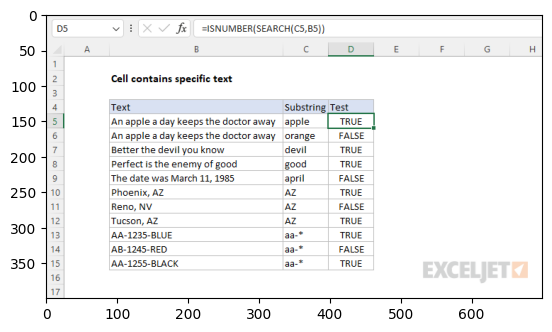

In [26]:
from app.ingestion.loader import Documentloader
import fitz
from PIL import Image
import io 
import pytesseract
from pytesseract import Output
import matplotlib.pyplot as plt
def extract_text_from_pdf_images(pdf_path:str)->str:
        """
        Extract images from PDF pages and run OCR on them
        """
        try:
            print("This is the helper function to extract text from images")
            text=""
            doc=fitz.open(pdf_path)
            for page_num in range(len(doc)):
                page=doc[page_num]

                image_list=page.get_images(full=True)
              
                for image_index,img in enumerate(image_list):
                    xref=img[0]
                    base_image=doc.extract_image(xref)

                    image_bytes=base_image["image"]

                    image=Image.open(io.BytesIO(image_bytes))
                    plt.imshow(image)
                    # text+=pytesseract.image_to_string(image)
                    text = pytesseract.image_to_data(image,output_type=Output.DATAFRAME)
                    # print("OCR SAMPLE:", text[:200])  

            return text
        except Exception as e:
            print(f"Error in extract_text_from_pdf_images function with {e}")
doc_text=extract_text_from_pdf_images('data/Doc2.pdf')
doc_text



In [38]:
rows=(doc_text.dropna(subset=["text"]).groupby("line_num")["text"].apply(lambda x: " ".join(x)).tolist())
for row in rows:
    print(row)

ps vei fe =ISNUMBER(SEARCH(C5,B5)) Cell contains specific text Text Perfect is the enemy of good The date was March 11, 1985 Phoenix, AZ Reno, NV Tucson, AZ ‘AA-1235-BLUE ‘AB-1245-RED ‘AA-1255-BLACK c D orange FALSE    
‘An apple a day keeps the doctor away Substring Test devil TRUE
‘An apple a day keeps the doctor away apple good TRUE
Better the devil you know: april FALSE
AZ TRUE
AZ FALSE
AZ TRUE
aa TRUE
aa FALSE
aa TRUE


In [15]:
rows = (
    doc_text.dropna(subset=["text"])
        .groupby("line_num")["text"]
        .apply(lambda x: " ".join(x))
        .tolist()
)

for row in rows:
    print(row)


      Delsjs BM CSUs                                                


In [41]:
pip install chromadb

  Using cached build-1.3.0-py3-none-any.whl.metadata (5.6 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached overrides-7.7.0-py3-none-any.whl.metadata (5.8 kB)
  Using cached importlib_resources-6.5.2-py3-none-any.whl.metadata (3.9 kB)
  Using cached grpcio-1.76.0-cp310-cp310-win_amd64.whl.metadata (3.8 kB)
  Using cached bcrypt-5.0.0-cp39-abi3-win_amd64.whl.metadata (10 kB)
  Using cached typer-0.20.0-py3-none-any.whl.metadata (16 kB)
  Using cached pyproject_hooks-1.2.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached websocket_client-1.9.0-py3-none-any.whl.metadata (8.3 kB)
  Using cached googleapis_common_protos-1.72.0-py3-none-any.whl.metadata (9.4 kB)
  Using cached shellingham-1.5.4-py

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mlflow 2.10.2 requires protobuf<5,>=3.12.0, but you have protobuf 6.33.2 which is incompatible.
opentelemetry-instrumentation 0.59b0 requires opentelemetry-semantic-conventions==0.59b0, but you have opentelemetry-semantic-conventions 0.60b1 which is incompatible.
opentelemetry-instrumentation-asgi 0.59b0 requires opentelemetry-semantic-conventions==0.59b0, but you have opentelemetry-semantic-conventions 0.60b1 which is incompatible.
opentelemetry-instrumentation-dbapi 0.59b0 requires opentelemetry-semantic-conventions==0.59b0, but you have opentelemetry-semantic-conventions 0.60b1 which is incompatible.
opentelemetry-instrumentation-django 0.59b0 requires opentelemetry-semantic-conventions==0.59b0, but you have opentelemetry-semantic-conventions 0.60b1 which is incompatible.
opentelemetry-instrumentation-fastapi 0

In [ ]:
import chromadb
import os
import chromadb

client = chromadb.CloudClient(
  api_key='',
  tenant='4dcc3f08-c729-4a52-b9e4-2912e40a59bd',
  database='RagTextImage'
)

In [50]:
pip install pymupdf pillow

Note: you may need to restart the kernel to use updated packages.


In [51]:
import os
import fitz  # pymupdf
from typing import List,Dict,Any
from PIL import Image
import numpy as np
from sentence_transformers import SentenceTransformer
import chromadb

c:\Users\santh\anaconda3\envs\rag\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [52]:
pdf_path='data/HealthCareSectorinindia-AnOverview.pdf'
image_dir='data/images'
os.makedirs(image_dir,exist_ok=True)


In [53]:
FIG_COLLECTION_NAME="healthcare_images"
TEXT_COLLECTION_NAME="healthcare_texts"

In [147]:
import torch
import numpy as np
from PIL import Image
from transformers import CLIPProcessor, CLIPModel

device = "cuda" if torch.cuda.is_available() else "cpu"

clip_model = CLIPModel.from_pretrained("clip-ViT-B-32").to(device)
clip_processor = CLIPProcessor.from_pretrained("lip-ViT-B-32")


OSError: clip-ViT-B-32 is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`

In [54]:
clip_model=SentenceTransformer('clip-ViT-B-32')#512 dimension 

.gitattributes: 100%|██████████| 756/756 [00:00<?, ?B/s] 
config.json: 4.03kB [00:00, ?B/s]
merges.txt: 525kB [00:00, 10.1MB/s]
model.safetensors: 100%|██████████| 605M/605M [01:10<00:00, 8.56MB/s] 
preprocessor_config.json: 100%|██████████| 316/316 [00:00<00:00, 314kB/s]
pytorch_model.bin: 100%|██████████| 605M/605M [01:10<00:00, 8.62MB/s] 
tokenizer_config.json: 100%|██████████| 604/604 [00:00<00:00, 301kB/s]
vocab.json: 961kB [00:00, 24.1MB/s]
README.md: 1.91kB [00:00, ?B/s]
modules.json: 100%|██████████| 122/122 [00:00<?, ?B/s] 


In [152]:
def embed_image(path:str)->np.ndarray:
    img=Image.open(path).convert('RGB')
    emb=clip_model.encode([img],convert_to_numpy=True,show_progress_bar=True)
    return emb[0]

def embed_text(text:str)->np.ndarray:
    emb=clip_model.encode([text],convert_to_numpy=True,show_progress_bar=False)
    print(emb[0].shape)
    return emb[0]

In [97]:
doc=fitz.open(pdf_path)
for i in doc:
    blocks=i.get_text("blocks")
    print(blocks)
    text_blocks = [b for b in blocks if b[4].strip()]  # keep non-empty text blocks
    print(f"Non-empty text blockstext_blocks: \n {text_blocks}")



[(167.16000366210938, 70.30220031738281, 431.5472412109375, 89.74760437011719, 'Health Care System in India : An Overview \n', 0, 0), (488.2799987792969, 94.51679229736328, 550.0800170898438, 112.21199798583984, 'A. Sheeba ∗ \n', 1, 0), (460.55999755859375, 116.59680938720703, 550.0800170898438, 134.29200744628906, '   Dr. A. Seilan ∗∗ \n', 2, 0), (48.2400016784668, 135.72300720214844, 508.31982421875, 155.05198669433594, 'This article published in the edited book titled \n: International issues on Health Economics \n', 3, 0), (305.6400146484375, 159.6840057373047, 390.80999755859375, 176.8889923095703, 'and Management \n', 4, 0), (48.2400016784668, 179.42840576171875, 365.489990234375, 198.04171752929688, 'Edited By \n: Dr. Arulraj \n', 5, 0), (48.2400016784668, 201.5084228515625, 508.55999755859375, 220.96176147460938, 'Published  by \n: TISSL \nInternational \nPublications, \n', 6, 0), (305.6400146484375, 224.7884521484375, 397.6499938964844, 243.40176391601562, 'New Delhi, India \n

In [59]:
for i in doc:
    print(i.get_images())

[]
[]
[]
[]
[]
[]
[]
[]
[]
[(24, 0, 411, 354, 8, 'Indexed', '', 'Im0', 'FlateDecode')]
[(27, 0, 731, 494, 8, 'ICCBased', '', 'Im0', 'FlateDecode')]
[(30, 0, 751, 423, 8, 'ICCBased', '', 'Im0', 'FlateDecode')]
[]
[]
[]
[]
[]
[]
[]


In [ ]:
image_records: List[Dict[str, Any]] = []

for page_index,page in enumerate(doc):
    blocks=page.get_text('blocks') #x0,y0,x1,y1,text,...
    text_blocks=[b for b in blocks if b[4].strip()] # keep non-empty text blocks
    print(text_blocks)
    images=page.get_images(full=True)
    print(f"page {page_index} and found {len(images)} images")

    for img_index,img in enumerate(images):
        xref=img[0]
        print(f"Image :{img}")
        print(f"Image reference:{xref}")
        rects = page.get_image_rects(xref)
        if not rects:
            continue
        rect=rects[0]
        print(f"reference : {rect}")
        above_blocks = [b for b in text_blocks if b[3] <= rect.y0]


        below_blocks=[b for b in text_blocks if b[0]<=rect.y0]
        print(f"Below blocks:{below_blocks}")
        candidate_blocks=below_blocks if below_blocks else text_blocks
        print(f"Candidate blocks:{candidate_blocks}")
        if candidate_blocks:
            closest_block = min(candidate_blocks, key=lambda b: abs(b[3] - rect.y0))
            caption_text = closest_block[4].strip().replace("\n", " ")
            print(f"closest block:{closest_block}")
        else:
            caption_text=""
        print(caption_text)

        #extract image and save
        img_data=doc.extract_image(xref)
        img_bytes=img_data['image']
        img_ext=img_data.get('ext','png')
        img_file_name=f"page{page_index:02d}_img_{img_index}.{img_ext}"
        img_path=os.path.join(image_dir,img_file_name)
        pix = page.get_pixmap(
            matrix=fitz.Matrix(1, 1),
            clip=rect)
        pix.save(img_path)

        image_records.append({
            "id":f"{page_index}_img{img_index}",
            "page_number":page_index,
            "bbox_x0":float(rect.x0),
            "bbox_y0":float(rect.y0),
            "bbox_x1":float(rect.x1),
            "bbox_y1":float(rect.y1),
            "caption_text":caption_text,
            "image_path":img_path
        }                
        )
image_records


[(167.16000366210938, 70.30220031738281, 431.5472412109375, 89.74760437011719, 'Health Care System in India : An Overview \n', 0, 0), (488.2799987792969, 94.51679229736328, 550.0800170898438, 112.21199798583984, 'A. Sheeba ∗ \n', 1, 0), (460.55999755859375, 116.59680938720703, 550.0800170898438, 134.29200744628906, '   Dr. A. Seilan ∗∗ \n', 2, 0), (48.2400016784668, 135.72300720214844, 508.31982421875, 155.05198669433594, 'This article published in the edited book titled \n: International issues on Health Economics \n', 3, 0), (305.6400146484375, 159.6840057373047, 390.80999755859375, 176.8889923095703, 'and Management \n', 4, 0), (48.2400016784668, 179.42840576171875, 365.489990234375, 198.04171752929688, 'Edited By \n: Dr. Arulraj \n', 5, 0), (48.2400016784668, 201.5084228515625, 508.55999755859375, 220.96176147460938, 'Published  by \n: TISSL \nInternational \nPublications, \n', 6, 0), (305.6400146484375, 224.7884521484375, 397.6499938964844, 243.40176391601562, 'New Delhi, India \n

[{'id': '9_img0',
  'page_number': 9,
  'bbox_x0': 85.89997863769531,
  'bbox_y0': 320.39990234375,
  'bbox_x1': 508.8206787109375,
  'bbox_y1': 576.3373413085938,
  'caption_text': 'Health Expenditure',
  'image_path': 'data/images\\page09_img_0.png'},
 {'id': '10_img0',
  'page_number': 10,
  'bbox_x0': 48.30998229980469,
  'bbox_y0': 72.05999755859375,
  'bbox_x1': 463.2669677734375,
  'bbox_y1': 351.9140319824219,
  'caption_text': 'The government expenditure on health has increased from 7938.36 crore in 1993-94 to 23028.3',
  'image_path': 'data/images\\page10_img_0.png'},
 {'id': '11_img0',
  'page_number': 11,
  'bbox_x0': 48.30998229980469,
  'bbox_y0': 72.06001281738281,
  'bbox_x1': 463.25506591796875,
  'bbox_y1': 292.85260009765625,
  'caption_text': 'The state government expenditure as a percentage of total expenditure has decreased from 4.96',
  'image_path': 'data/images\\page11_img_0.png'}]

In [139]:
text_records:List[Dict[str,any]]=[]
print("Extracting text chunks")
MIN_CHARS=80
for page_index,page in enumerate(doc):
    blocks=page.get_text("blocks")
    for block_idx,b in enumerate(blocks):
        text=b[4].strip()
        if len(text)<MIN_CHARS:
            continue
        x0,y0,x1,y1=b[0],b[1],b[2],b[3]

        text_records.append({
            "id":f"{page_index}_block{block_idx}",
            "page_number":page_index,
            "bbox_x0":float(x0),
            "bbox_y0":float(y0),
            "bbox_x1":float(x1),
            "bbox_y1":float(y1),
            "text":text
        })

text_records


Extracting text chunks


[{'id': '0_block3',
  'page_number': 0,
  'bbox_x0': 48.2400016784668,
  'bbox_y0': 135.72300720214844,
  'bbox_x1': 508.31982421875,
  'bbox_y1': 155.05198669433594,
  'text': 'This article published in the edited book titled \n: International issues on Health Economics'},
 {'id': '0_block12',
  'page_number': 0,
  'bbox_x0': 81.23999786376953,
  'bbox_y0': 340.40399169921875,
  'bbox_x1': 550.0797729492188,
  'bbox_y1': 356.4119873046875,
  'text': 'Health care is the prevention, treatment, and management of illness and the preservation of'},
 {'id': '0_block13',
  'page_number': 0,
  'bbox_x0': 48.24000549316406,
  'bbox_y0': 361.04400634765625,
  'bbox_x1': 550.079833984375,
  'bbox_y1': 377.052001953125,
  'text': 'mental and physical well being through the services offered by the medical, nursing, and allied health'},
 {'id': '0_block14',
  'page_number': 0,
  'bbox_x0': 48.24000549316406,
  'bbox_y0': 381.80401611328125,
  'bbox_x1': 550.0798950195312,
  'bbox_y1': 397.812011718

In [148]:
fig_collection=client.get_or_create_collection(
    name=FIG_COLLECTION_NAME,
    metadata={"type":"image","source":"health pdf","model":"clip-ViT-B-32"}
)

text_collection=client.get_or_create_collection(
    name=TEXT_COLLECTION_NAME,
    metadata={"type":"text","source":"health pdf","model":"clip-ViT-B-32"}
)

In [149]:
fig_ids=[]
fig_embeddings=[]
fig_metadata=[]
fig_documents=[]

for rec in image_records:
    img_embed=embed_image(rec['image_path'])
    fig_ids.append(rec['id'])
    fig_embeddings.append(img_embed)
    fig_metadata.append({
        "page_number":int(rec['page_number']),
        "bbox_x0":rec['bbox_x0'],
        "bbox_y0":rec['bbox_y0'],
        "bbox_x1":rec['bbox_x1'],
        "bbox_y1":rec['bbox_y1'],
        "image_path":rec['image_path'],
        "caption":rec['caption_text']
    })
    fig_documents.append(
        f"Image from Health care documents on page {rec['page_number']}. "
        f"Caption {rec['caption_text']}"
    )

if fig_ids:
    fig_collection.add(
        ids=fig_ids,
        embeddings=fig_embeddings,
        metadatas=fig_metadata,
        documents=fig_documents
    )

Batches: 100%|██████████| 1/1 [00:00<00:00, 15.24it/s]


In [157]:
text_ids=[]
text_embeddings=[]
text_metadata=[]
text_documents=[]
try:
    for rec in text_records:
        print(len(rec['text']))
        emb = embed_text(rec["text"])

        text_ids.append(rec["id"])
        text_embeddings.append(emb.tolist())
        text_metadata.append({
            "page_number": int(rec["page_number"]),
            "bbox_x0": rec["bbox_x0"],
            "bbox_y0": rec["bbox_y0"],
            "bbox_x1": rec["bbox_x1"],
            "bbox_y1": rec["bbox_y1"],
        })
        text_documents.append(rec["text"])

        if text_ids:
            text_collection.add(
            ids=text_ids,
            embeddings=text_embeddings,
            metadatas=text_metadata,
            documents=text_documents,
            )
except Exception as e:
    print(f'Error in embedding {e}')

92
(512,)
91
(512,)
102
(512,)
95
(512,)
98
(512,)
96
(512,)
96
(512,)
94
(512,)
99
(512,)
102
(512,)
104
(512,)
86
(512,)
88
(512,)
94
(512,)
100
(512,)
89
(512,)
98
(512,)
95
(512,)
96
(512,)
103
(512,)
93
(512,)
96
(512,)
103
(512,)
95
(512,)
94
(512,)
97
(512,)
100
(512,)
108
(512,)
99
(512,)
100
(512,)
101
(512,)
99
(512,)
92
(512,)
102
(512,)
100
(512,)
101
(512,)
88
(512,)
99
(512,)
89
(512,)
100
(512,)
96
(512,)
83
(512,)
94
(512,)
102
(512,)
101
(512,)
97
(512,)
100
(512,)
104
(512,)
96
(512,)
92
(512,)
102
(512,)
104
(512,)
100
(512,)
98
(512,)
99
(512,)
99
(512,)
91
(512,)
94
(512,)
100
(512,)
97
(512,)
93
(512,)
94
(512,)
97
(512,)
106
(512,)
80
(512,)
98
(512,)
94
(512,)
96
(512,)
101
(512,)
97
(512,)
107
(512,)
100
(512,)
109
(512,)
86
(512,)
97
(512,)
99
(512,)
103
(512,)
105
(512,)
103
(512,)
100
(512,)
92
(512,)
100
(512,)
105
(512,)
92
(512,)
102
(512,)
104
(512,)
103
(512,)
97
(512,)
80
(512,)
80
(512,)
83
(512,)
93
(512,)
94
(512,)
93
(512,)
105
(512,)
92
(512,)
97


In [158]:
def answer_query(
    query: str,
    top_k_text: int = 5,
    top_k_img: int = 5,
    top_k_overall: int = 8,
) -> List[Dict[str, Any]]:
    """
    Search both text chunks and images in Chroma Cloud,
    merge results by distance, and return/print top hits.
    """
    q_emb = embed_text(query)

    combined: List[Dict[str, Any]] = []

    # --- Text search ---
    text_results = text_collection.query(
        query_embeddings=[q_emb.tolist()],
        n_results=top_k_text,
        include=["metadatas", "documents", "distances"],
    )

    for meta, doc, dist in zip(
        text_results["metadatas"][0],
        text_results["documents"][0],
        text_results["distances"][0],
    ):
        combined.append({
            "type": "text",
            "distance": float(dist),
            "page_number": meta["page_number"],
            "bbox": (
                meta["bbox_x0"],
                meta["bbox_y0"],
                meta["bbox_x1"],
                meta["bbox_y1"],
            ),
            "content": doc,
        })

    # --- Image search ---
    fig_results = fig_collection.query(
        query_embeddings=[q_emb.tolist()],
        n_results=top_k_img,
        include=["metadatas", "documents", "distances"],
    )

    for meta, doc, dist in zip(
        fig_results["metadatas"][0],
        fig_results["documents"][0],
        fig_results["distances"][0],
    ):
        combined.append({
            "type": "image",
            "distance": float(dist),
            "page_number": meta["page_number"],
            "image_path": meta["image_path"],
            "caption": meta.get("caption", ""),
            "content": doc,
        })

    # Sort by similarity (lower distance = more similar)
    combined.sort(key=lambda x: x["distance"])
    combined = combined[:top_k_overall]

    # Pretty-print
    print(f"\n=== Query: {query} ===")
    for rank, item in enumerate(combined, start=1):
        print(f"\nRank {rank} | type: {item['type']} | distance: {item['distance']:.4f}")
        print("  Page:", item["page_number"])
        if item["type"] == "text":
            preview = item["content"].replace("\n", " ")
            if len(preview) > 260:
                preview = preview[:260] + "..."
            print("  Text:", preview)
        else:
            print("  Image path:", item["image_path"])
            print("  Caption   :", item.get("caption", ""))

    return combined

In [159]:
answer_query("major components of the Indian health care sector?",top_k_text=3,top_k_img=3,top_k_overall=5)

(512,)

=== Query: major components of the Indian health care sector? ===

Rank 1 | type: text | distance: 15.4262
  Page: 11
  Text: health care sector in India has been growing at an enormous pace. During 2002, India's health care

Rank 2 | type: text | distance: 16.6253
  Page: 6
  Text: India is encouraging investment in healthcare sector; over the years, the private sector in India

Rank 3 | type: text | distance: 18.6528
  Page: 6
  Text: overwhelming presence of the private sector in health, various state governments in India have been

Rank 4 | type: image | distance: 131.9420
  Page: 9
  Image path: data/images\page09_img_0.png
  Caption   : Health Expenditure

Rank 5 | type: image | distance: 137.2316
  Page: 10
  Image path: data/images\page10_img_0.png
  Caption   : The government expenditure on health has increased from 7938.36 crore in 1993-94 to 23028.3


[{'type': 'text',
  'distance': 15.426212,
  'page_number': 11,
  'bbox': (48.24000549316406,
   409.16400146484375,
   550.080078125,
   425.1719970703125),
  'content': "health care sector in India has been growing at an enormous pace. During 2002, India's health care"},
 {'type': 'text',
  'distance': 16.625343,
  'page_number': 6,
  'bbox': (48.2400016784668,
   222.9239959716797,
   550.0797119140625,
   238.93199157714844),
  'content': 'India is encouraging investment in healthcare sector; over the years, the private sector in India'},
 {'type': 'text',
  'distance': 18.652771,
  'page_number': 6,
  'bbox': (48.239959716796875,
   554.1242065429688,
   550.0799560546875,
   570.1322021484375),
  'content': 'overwhelming presence of the private sector in health, various state governments in India have been'},
 {'type': 'image',
  'distance': 131.94203,
  'page_number': 9,
  'image_path': 'data/images\\page09_img_0.png',
  'caption': 'Health Expenditure',
  'content': 'Image from 

In [165]:
pip install euriai

Note: you may need to restart the kernel to use updated packages.


In [167]:
from euriai import EuriaiClient
chat_model = EuriaiClient(
    api_key=os.getenv('OPENAI_API_KEY'),
    model="gpt-4.1-nano"
)

In [171]:
response=chat_model.generate_completion(
    prompt="What is artificial intelligence?",
    temperature=0.7,
    max_tokens=1000
)


In [179]:
import hashlib
def chunk_id(doc_id,chunk_index,text):
    h=hashlib.sha256(text.encode("utf-8")).hexdigest()[:8]
    return f"{doc_id}_c{chunk_index}_{h}"
chunk_id(1,23,'the salmon is good and ')   

'1_c23_961f307d'

In [ ]:
def is_heading(line: str) -> bool:
    if line.isupper() and len(line) < 60:
        return True
    if line.endswith(":"):
        return True
    if len(line.split()) <= 4 and line.istitle():
        return True
    return False
def segment_resume(text: str):
    sections = []
    current_section = {"title": "UNKNOWN", "content": []}

    for line in text.split("\n"):
        line = line.strip()
        if not line:
            continue

        if is_heading(line):
            sections.append(current_section)
            current_section = {"title": line, "content": []}
        else:
            current_section["content"].append(line)

    sections.append(current_section)
    return sections


In [4]:
segment_resume('Machine Learning Engineer with 3 years of ML experience and 4.8 years of overall IT')

[{'title': 'UNKNOWN',
  'content': ['Machine Learning Engineer with 3 years of ML experience and 4.8 years of overall IT']}]

In [7]:
from sqlalchemy.ext.asyncio import create_async_engine, AsyncSession
from sqlalchemy.orm import sessionmaker
import os
from dotenv import load_dotenv

load_dotenv()

DATABASE_URL = os.getenv("DATABASE_URL").replace(
    "postgresql://", "postgresql+asyncpg://"
)

engine = create_async_engine(DATABASE_URL, echo=False)

AsyncSessionLocal = sessionmaker(
    bind=engine,
    class_=AsyncSession,
    expire_on_commit=False
)

async def get_db():
    async with AsyncSessionLocal() as session:
        yield session

get_db()

<async_generator object get_db at 0x000002E454790EC0>

In [3]:
cd ..

e:\GENAI\clinical-rag


c:\Users\santh\anaconda3\envs\rag\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [8]:
# scripts/init_db.py
import asyncio
from app.db.database import engine
from app.db.models import Base

async def init():
    async with engine.begin() as conn:
        await conn.run_sync(Base.metadata.create_all)

asyncio.run(init())


c:\Users\santh\anaconda3\envs\rag\lib\ast.py:272: RuntimeWarning: coroutine 'init' was never awaited
  for name, field in iter_fields(node):


RuntimeError: asyncio.run() cannot be called from a running event loop

In [6]:
pwd

'e:\\GENAI\\clinical-rag\\notebooks'

In [3]:
import asyncio,aiofiles
from typing import List,Optional
async def read_file_async(file_path:str)->Optional[str]:
    try:
        async with aiofiles.open(file_path,mode='r',encoding='utf-8')as f:
            content=await f.read()
            return content
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
        return None

async def read_files_async(file_paths:List[str])->List[Optional[str]]:

    tasks=[read_file_async(fp) for fp in file_paths]
    results=await asyncio.gather(*tasks)
    return list(results)

async def main():
    files=['file.txt','file2.txt','file3.txt']
    print("reading files")
    output=await read_files_async(files)
    for i,(filename, content) in enumerate(zip(files, output)):
        if content is not None:
            print(f"{i+1}. {filename}: Read {len(content)} characters")
        else:
            print(f"{i+1}. {filename}: Failed to read (None)")
    
    return output


In [5]:
if __name__ == "__main__":
    output = asyncio.run(main())
    print("\nOutput list:", output)

RuntimeError: asyncio.run() cannot be called from a running event loop

In [7]:
import asyncio
import aiofiles
from typing import List, Optional


async def read_file_async(filepath: str) -> Optional[str]:
    """
    Read a single file asynchronously.
    Returns file content as string, or None if file cannot be read.
    """
    try:
        async with aiofiles.open(filepath, mode='r', encoding='utf-8') as f:
            content = await f.read()
            return content
    except Exception as e:
        print(f"Error reading {filepath}: {e}")
        return None


async def read_files_async(filepaths: List[str]) -> List[Optional[str]]:
    """
    Read multiple files asynchronously.
    Returns list of file contents in the same order as input filepaths.
    If a file cannot be read, None is placed at that position.
    """
    tasks = [read_file_async(filepath) for filepath in filepaths]
    results = await asyncio.gather(*tasks)
    return list(results)


async def main():
    # Example usage
    files = ['file.txt', 'file1.txt', 'file3.txt', 'nonexistent.txt']
    
    print("Reading files asynchronously...")
    output = await read_files_async(files)
    
    print("\nResults:")
    for i, (filename, content) in enumerate(zip(files, output)):
        if content is not None:
            print(f"{i+1}. {filename}: Read {len(content)} characters")
        else:
            print(f"{i+1}. {filename}: Failed to read (None)")
    
    return output


# Run the async function
if __name__ == "__main__":
    output = asyncio.run(main())
    print("\nOutput list:", output)

c:\Users\santh\anaconda3\envs\rag\lib\site-packages\executing\executing.py:177: RuntimeWarning: coroutine 'main' was never awaited
  source_cache = cls._class_local('__source_cache_with_lines', {}) # type: Dict[Tuple[str, Sequence[str]], Source]


RuntimeError: asyncio.run() cannot be called from a running event loop

In [7]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
X = df[["age", "bp", "cholesterol"]]
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["feature"] = X.columns
vif

NameError: name 'df' is not defined

In [2]:
pip install prophet


   ---------------------------------------- 0.0/12.1 MB ? eta -:--:--
   - -------------------------------------- 0.5/12.1 MB 4.2 MB/s eta 0:00:03
   ---- ----------------------------------- 1.3/12.1 MB 4.2 MB/s eta 0:00:03
   ------- -------------------------------- 2.4/12.1 MB 4.2 MB/s eta 0:00:03
   ----------- ---------------------------- 3.4/12.1 MB 4.3 MB/s eta 0:00:03
   -------------- ------------------------- 4.5/12.1 MB 4.5 MB/s eta 0:00:02
   ----------------- ---------------------- 5.2/12.1 MB 4.5 MB/s eta 0:00:02
   -------------------- ------------------- 6.3/12.1 MB 4.5 MB/s eta 0:00:02
   -------------------------- ------------- 8.1/12.1 MB 5.0 MB/s eta 0:00:01
   -------------------------------- ------- 9.7/12.1 MB 5.3 MB/s eta 0:00:01
   --------------------------------- ------ 10.2/12.1 MB 5.1 MB/s eta 0:00:01
   -------------------------------------- - 11.8/12.1 MB 5.2 MB/s eta 0:00:01
   ---------------------------------------- 12.1/12.1 MB 5.1 MB/s  0:00:02
   --

c:\Users\santh\anaconda3\envs\rag\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
11:57:54 - cmdstanpy - INFO - Chain [1] start processing
11:57:55 - cmdstanpy - INFO - Chain [1] done processing


            ds        yhat  yhat_lower  yhat_upper
390 2021-01-25  109.510098  107.071781  112.143427
391 2021-01-26  109.571380  106.984478  112.289820
392 2021-01-27  109.640388  106.986711  112.324539
393 2021-01-28  109.398273  106.662833  112.046461
394 2021-01-29  109.186792  106.397465  111.831369


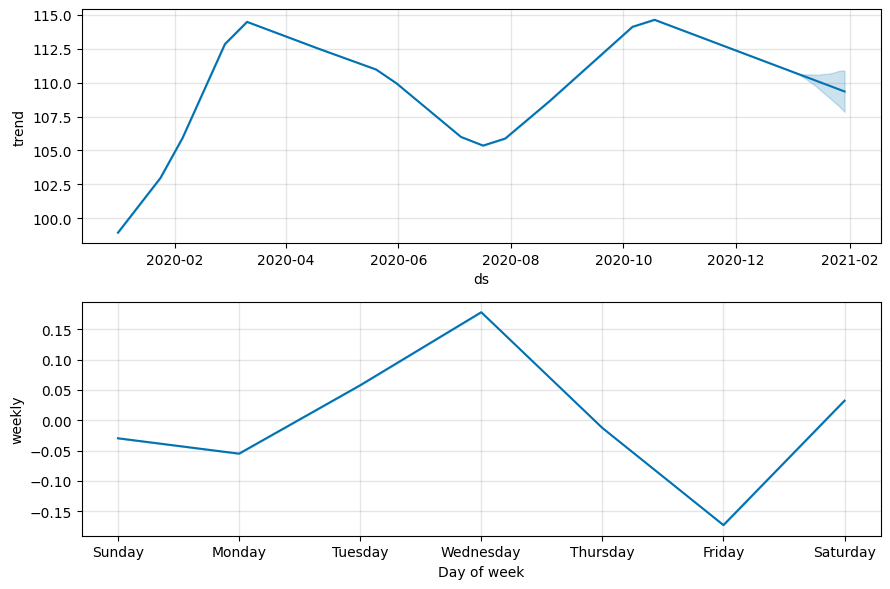

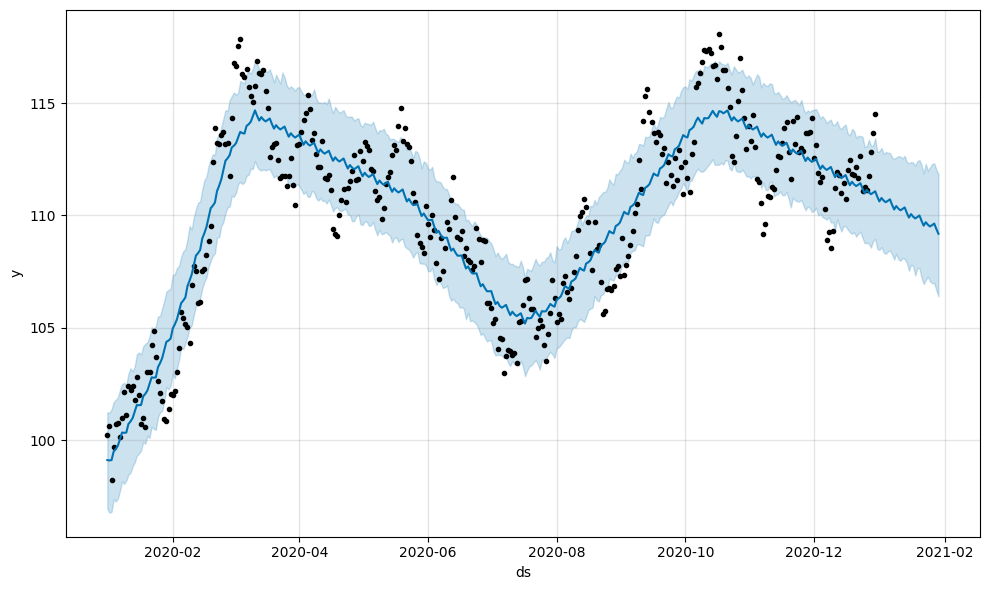

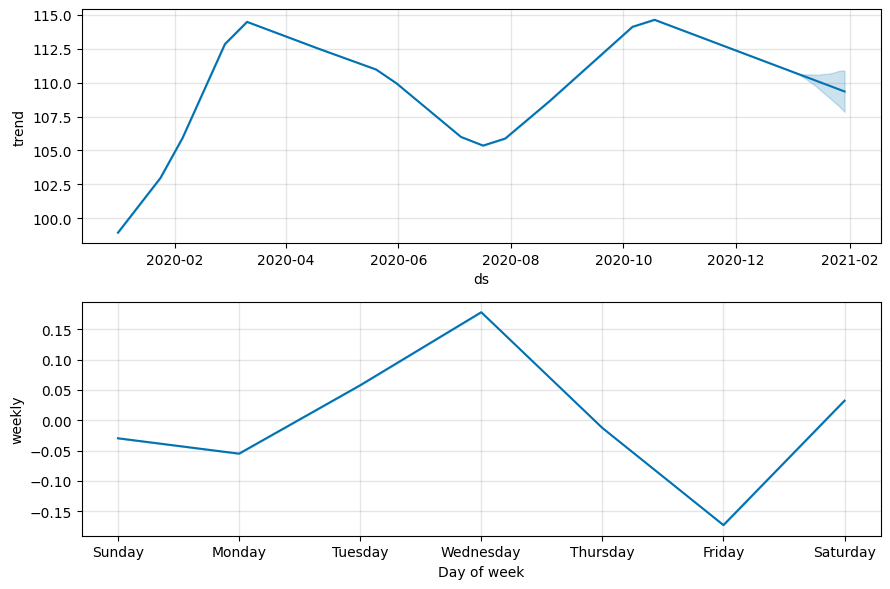

In [3]:
# Using Prophet
from prophet import Prophet
import pandas as pd
import numpy as np

# Create sample time series data
dates = pd.date_range('2020-01-01', periods=365)
values = np.cumsum(np.random.randn(365)) + 100

df = pd.DataFrame({'ds': dates, 'y': values})

# Fit Prophet model
model = Prophet()
model.fit(df)

# Make future predictions
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

# Plot
model.plot(forecast)
model.plot_components(forecast)

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd
import numpy as np

# Create seasonal time series
dates = pd.date_range('2020-01-01', periods=365, freq='D')
trend = np.linspace(0, 10, 365)
seasonal = 5 * np.sin(np.arange(365) * 2 * np.pi / 365)
noise = np.random.randn(365)
ts = pd.Series(trend + seasonal + noise, index=dates)

# Decompose into components
decomposition = seasonal_decompose(ts, model='additive', period=365)

# Plot components
import matplotlib.pyplot as plt
fig = decomposition.plot()
plt.show()

# Extract components
trend_component = decomposition.trend
seasonal_component = decomposition.seasonal
residual = decomposition.resid

print("Seasonal component (first 10 days):")
print(seasonal_component.head(10))

ValueError: x must have 2 complete cycles requires 730 observations. x only has 365 observation(s)

In [6]:
import pandas as pd
import numpy as np

# Create sample data
df = pd.DataFrame({
    'date': pd.date_range('2024-01-01', periods=100),
    'value': np.random.randn(100),
    'category': np.random.choice(['A', 'B', 'C'], 100)
})

# Pandas operations
df['value_squared'] = df['value'] ** 2
df['rolling_mean'] = df['value'].rolling(window=7).mean()
grouped = df.groupby('category')['value'].agg(['mean', 'std', 'count'])

print("Grouped statistics:")
print(grouped)

# NumPy operations
arr = df['value'].values
normalized = (arr - np.mean(arr)) / np.std(arr)
percentiles = np.percentile(arr, [25, 50, 75])

print(f"\nPercentiles: {percentiles}")

Grouped statistics:
              mean       std  count
category                           
A         0.144394  1.116600     32
B        -0.205027  1.161601     44
C         0.120688  0.741765     24

Percentiles: [-0.62370855  0.0610458   0.52486367]


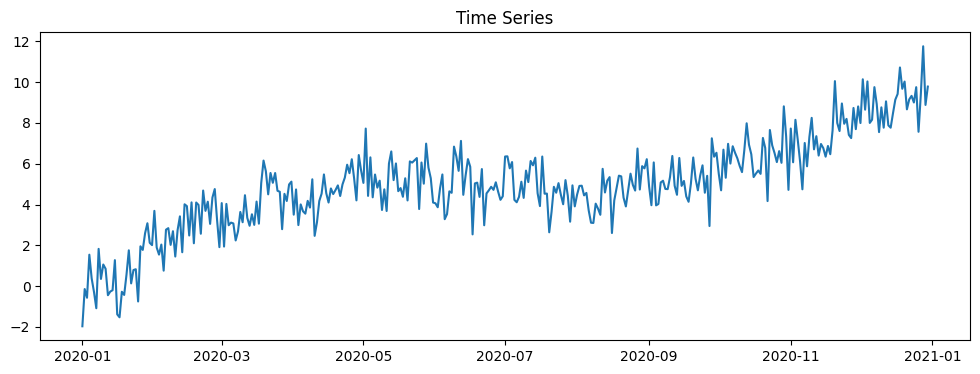

ADF Test Results:
ADF Statistic: -1.296254294830842
p-value: 0.6308842312410984
Series is NON-STATIONARY (fail to reject null hypothesis)
p-value: 0.01
Series is NON-STATIONARY


C:\Users\santh\AppData\Local\Temp\ipykernel_10776\3233733304.py:33: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series)


In [9]:
from statsmodels.tsa.stattools import adfuller, kpss
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Create non-stationary series (with trend)
dates = pd.date_range('2020-01-01', periods=365)
trend = np.linspace(0, 10, 365)
seasonal = 2 * np.sin(np.arange(365) * 2 * np.pi / 365)
noise = np.random.randn(365)
ts = pd.Series(trend + seasonal + noise, index=dates)

# 1. Visual inspection
plt.figure(figsize=(12, 4))
plt.plot(ts)
plt.title('Time Series')
plt.show()

# 2. ADF test
def check_stationarity(series):
    # ADF Test
    adf_result = adfuller(series)
    print('ADF Test Results:')
    print(f'ADF Statistic: {adf_result[0]}')
    print(f'p-value: {adf_result[1]}')
    
    if adf_result[1] < 0.05:
        print("Series is STATIONARY (reject null hypothesis)")
    else:
        print("Series is NON-STATIONARY (fail to reject null hypothesis)")
    
    # KPSS Test
    kpss_result = kpss(series)
    print(f'p-value: {kpss_result[1]}')
    if kpss_result[1] < 0.05:
        print("Series is NON-STATIONARY")
    else:
        print("Series is STATIONARY")
check_stationarity(ts)
